In [1]:
!pip install numpy -q
!pip install pandas -q
!pip install matplotlib -q
!pip install tensorflow -q

!pip install opendatasets -q

In [2]:
# import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import opendatasets as od

### Load Dataset

In [3]:
# download dataset
od.download("https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dineshpiyasamara
Your Kaggle Key: ··········


100%|██████████| 217M/217M [00:01<00:00, 119MB/s]


In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (128,128)

In [5]:
train_data_dir = "/content/cats-and-dogs-for-classification/cats_dogs/train"
test_data_dir = "/content/cats-and-dogs-for-classification/cats_dogs/test"

train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='training',
                                                         validation_split=0.1,
                                                         seed=42)

validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='validation',
                                                         validation_split=0.1,
                                                         seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

Found 8000 files belonging to 2 classes.
Using 7200 files for training.
Found 8000 files belonging to 2 classes.
Using 800 files for validation.
Found 2000 files belonging to 2 classes.


In [6]:
class_names = train_data.class_names
class_names

['cats', 'dogs']

In [7]:
for image_batch,label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(32, 128, 128, 3)
(32,)


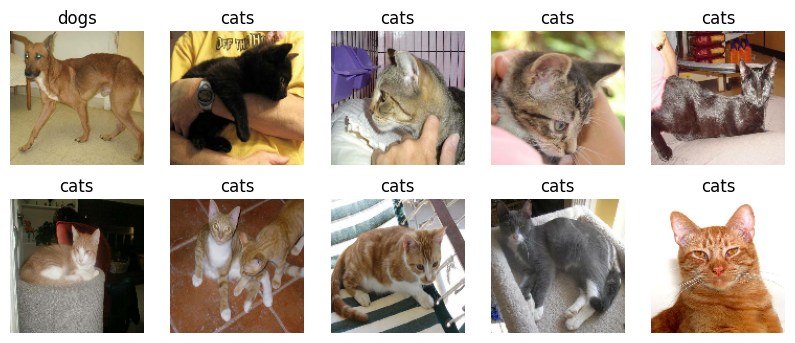

In [12]:
# plot data sample
plt.figure(figsize=(10,4))
for image,label in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

### Scaling Images

In [18]:
for image,label in train_data.take(1):
    for i in range(1):
      print(image)

tf.Tensor(
[[[[0.27993643 0.2720933  0.31523055]
   [0.28791934 0.28345588 0.33274645]
   [0.26288584 0.2646446  0.3180511 ]
   ...
   [0.09411765 0.03921569 0.00392157]
   [0.09411765 0.03921569 0.00392157]
   [0.09411765 0.03921569 0.00392157]]

  [[0.2783701  0.27052698 0.32150736]
   [0.2989995  0.29898706 0.34615216]
   [0.26747665 0.27531978 0.3291188 ]
   ...
   [0.09411765 0.03921569 0.00392157]
   [0.09411765 0.03921569 0.00392157]
   [0.09411765 0.03921569 0.00392157]]

  [[0.33783126 0.33740234 0.38531902]
   [0.29682714 0.29435605 0.34877452]
   [0.28149894 0.29075137 0.3445504 ]
   ...
   [0.09411765 0.03921569 0.00392157]
   [0.09411765 0.03921569 0.00392157]
   [0.09411765 0.03921569 0.00392157]]

  ...

  [[0.7763299  0.7449573  0.7880946 ]
   [0.7772059  0.7459559  0.78903186]
   [0.76164407 0.7418802  0.7826593 ]
   ...
   [0.26641965 0.21151769 0.19975299]
   [0.26668677 0.21178481 0.2000201 ]
   [0.2668074  0.21190545 0.20014074]]

  [[0.7670343  0.7435049  0.782720

In [17]:
train_data = train_data.map(lambda x,y:(x/255,y))
validation_data = validation_data.map(lambda x,y:(x/255,y))
test_data = test_data.map(lambda x,y:(x/255,y))

### Data Augmentation

In [19]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(128,128,3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
  ]
)

### Model Building

In [22]:
model = tf.keras.models.Sequential()

model.add(data_augmentation)

model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)      

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

### Model Training

In [25]:
start_time = time.time()

history = model.fit(train_data,
                    epochs=20,
                    validation_data=validation_data)

end_time = time.time()

Epoch 1/20
225/225 [==============================] - 25s 51ms/step - loss: 0.6596 - accuracy: 0.6110 - val_loss: 0.6663 - val_accuracy: 0.6675
Epoch 2/20
225/225 [==============================] - 10s 46ms/step - loss: 0.6414 - accuracy: 0.6351 - val_loss: 0.6022 - val_accuracy: 0.6812
Epoch 3/20
225/225 [==============================] - 11s 48ms/step - loss: 0.6110 - accuracy: 0.6621 - val_loss: 0.7562 - val_accuracy: 0.5713
Epoch 4/20
225/225 [==============================] - 11s 48ms/step - loss: 0.5951 - accuracy: 0.6806 - val_loss: 0.6716 - val_accuracy: 0.6275
Epoch 5/20
225/225 [==============================] - 10s 46ms/step - loss: 0.5794 - accuracy: 0.6889 - val_loss: 0.8054 - val_accuracy: 0.5512
Epoch 6/20
225/225 [==============================] - 9s 41ms/step - loss: 0.5686 - accuracy: 0.7010 - val_loss: 0.6624 - val_accuracy: 0.6825
Epoch 7/20
225/225 [==============================] - 10s 41ms/step - loss: 0.5464 - accuracy: 0.7193 - val_loss: 0.5190 - val_accuracy: 

In [26]:
print(f'Total time for training {(end_time-start_time):.3f} seconds')

Total time for training 290.314 seconds


### Performance Analysis

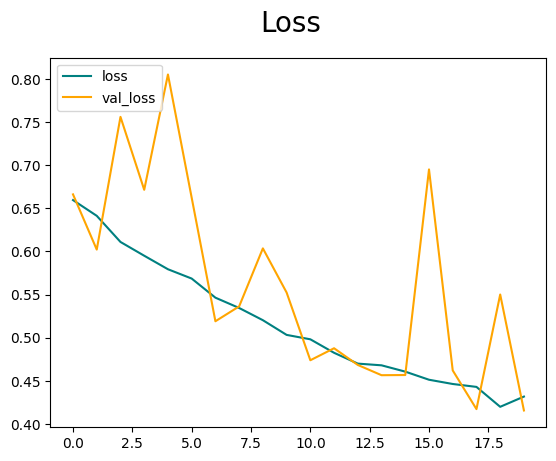

In [27]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

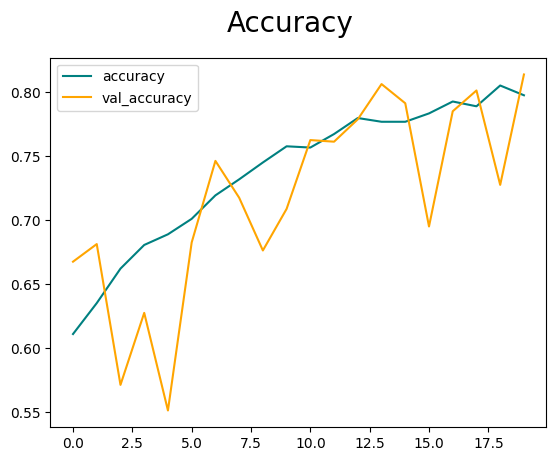

In [28]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()

### Model Evaluation

In [29]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

In [30]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 216ms/step


In [31]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.7392364>

In [32]:
recall.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.91>

In [33]:
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.7945>

### Test

In [34]:
!pip install opencv-python -q

In [42]:
import cv2

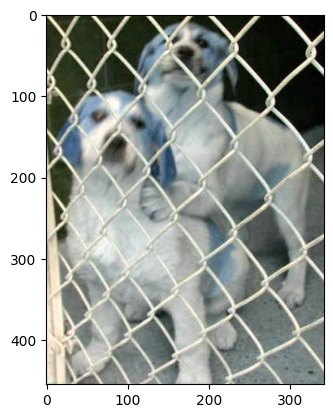

In [67]:
img = cv2.imread('/content/cats-and-dogs-for-classification/cats_dogs/test/dogs/dog.4008.jpg')
plt.imshow(img)
plt.show()

In [68]:
resized_image = tf.image.resize(img, IMAGE_SIZE)
scaled_image = resized_image/255

In [69]:
scaled_image.shape

TensorShape([128, 128, 3])

In [70]:
np.expand_dims(scaled_image, 0).shape

(1, 128, 128, 3)

In [71]:
yhat = model.predict(np.expand_dims(scaled_image, 0))

1/1 [==============================] - 0s 19ms/step


In [72]:
yhat

array([[0.92316616]], dtype=float32)

In [73]:
class_names

['cats', 'dogs']

In [74]:
if yhat > 0.5:
    print(f'{class_names[1]}')
else:
    print(f'{class_names[0]}')

dogs
